In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

In [3]:
import urllib.request
import zipfile
import os
import random
from shutil import copyfile, rmtree

random.seed(42)

# 데이터 분할 함수
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + ' is zero length, so ignoring.')

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

# 이미 cats-v-dogs 폴더가 있다면 데이터를 다시 다운받지 않습니다.
if not os.path.isdir('cats-v-dogs'):

    data_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
    data_file_name = 'catsdogs.zip'
    download_dir = './'
    urllib.request.urlretrieve(data_url, data_file_name)
    zip_ref = zipfile.ZipFile(data_file_name, 'r')
    zip_ref.extractall(download_dir)
    zip_ref.close()
    
    try:
        os.mkdir('./cats-v-dogs')
        os.mkdir('./cats-v-dogs/training')
        os.mkdir('./cats-v-dogs/testing')
        os.mkdir('./cats-v-dogs/training/cats')
        os.mkdir('./cats-v-dogs/training/dogs')
        os.mkdir('./cats-v-dogs/testing/cats')
        os.mkdir('./cats-v-dogs/testing/dogs')
    except OSError:
        pass
    
    CAT_SOURCE_DIR = './PetImages/Cat/'
    TRAINING_CATS_DIR = './cats-v-dogs/training/cats/'
    TESTING_CATS_DIR = './cats-v-dogs/testing/cats/'
    DOG_SOURCE_DIR = './PetImages/Dog/'
    TRAINING_DOGS_DIR = './cats-v-dogs/training/dogs/'
    TESTING_DOGS_DIR = './cats-v-dogs/testing/dogs/'

    split_size = .9
    split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
    split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
    
    rmtree('./PetImages')

In [4]:
print(len(os.listdir('./cats-v-dogs/training/cats/')))
print(len(os.listdir('./cats-v-dogs/training/dogs/')))
print(len(os.listdir('./cats-v-dogs/testing/cats/')))
print(len(os.listdir('./cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [5]:
TRAINING_DIR = "./cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=100,
    class_mode='binary',
    target_size=(150, 150)
)

VALIDATION_DIR = "./cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=100,
    class_mode='binary',
    target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)
pre_trained_model.load_weights(weights_file)

In [7]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed9')
last_output = last_layer.output

In [8]:
x = layers.Flatten()(last_output)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(train_generator,
          validation_data=validation_generator,
          epochs=20)

Epoch 1/10
210/225 [===========================>..] - ETA: 18s - loss: 0.1688 - acc: 0.9298

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

225/225 [==============================] - 334s 1s/step - loss: 0.1650 - acc: 0.9312 - val_loss: 0.0702 - val_acc: 0.9748
Epoch 2/10
225/225 [==============================] - 230s 1s/step - loss: 0.1308 - acc: 0.9473 - val_loss: 0.0560 - val_acc: 0.9768
Epoch 3/10
225/225 [==============================] - 227s 1s/step - loss: 0.1226 - acc: 0.9509 - val_loss: 0.0561 - val_acc: 0.9804
Epoch 4/10
225/225 [==============================] - 227s 1s/step - loss: 0.1141 - acc: 0.9556 - val_loss: 0.0550 - val_acc: 0.9800
Epoch 5/10
225/225 [==============================] - 225s 1s/step - loss: 0.1104 - acc: 0.9579 - val_loss: 0.0533 - val_acc: 0.9784
Epoch 6/10
225/225 [==============================] - 225s 1s/step - loss: 0.1113 - acc: 0.9566 - val_loss: 0.0608 - val_acc: 0.9768
Epoch 7/10
225/225 [==============================] - 228s 1s/step - loss: 0.1079 - acc: 0.9570 - val_loss: 0.0485 - val_acc: 0.9808
Epoch 8/10
225/225 [==============================] - 225s 1s/step - loss: 0.105

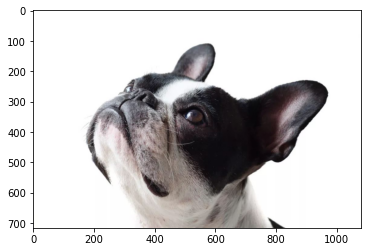

모델 출력: 0.0
cats-v-dogs-1.jpg는 고양이입니다.
--------------------


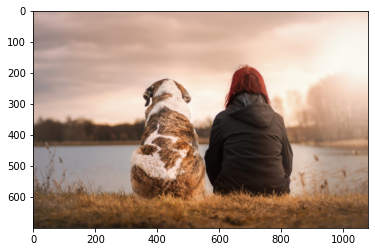

모델 출력: 0.0
cats-v-dogs-2.jpg는 고양이입니다.
--------------------


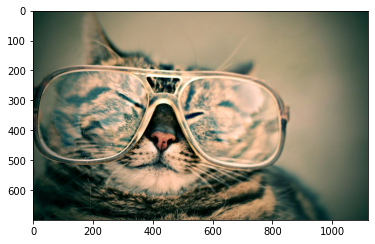

모델 출력: 1.0
cats-v-dogs-3.jpg는 강아지입니다.
--------------------


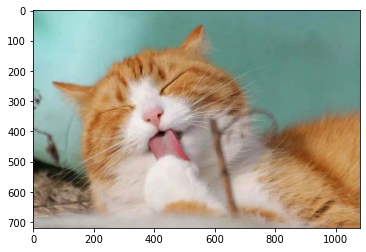

모델 출력: 0.0
cats-v-dogs-4.jpg는 고양이입니다.
--------------------


In [9]:
test_images = ['cats-v-dogs-{}.jpg'.format(i) for i in range(1,5)]

for fn in test_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = image.load_img(fn, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    classes = model.predict(x)

    print('모델 출력:', classes[0][0])
    if classes[0][0] > 0.5:
      print(fn + "는 강아지입니다.")
    else:
      print(fn + "는 고양이입니다.")
    print('--------------------')